<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="30%" />

# SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

## Deliverable 📬

To complete this project, your team should:

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

# Imports

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset = pd.read_csv("/content/drive/MyDrive/Fichiers/2.Scolarité/1. Jedha_Data_Science/CERTIF_PROJECTS/ML_Engineer_Certification_Projects/06_DEEP_LEARNING_At&t/src/src_spam.csv", on_bad_lines='skip', encoding = "cp1252")

# Dataset exploring

In [4]:
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
dataset["Unnamed: 3"].unique()

array([nan, ' MK17 92H. 450Ppw 16"', ' why to miss them', 'GE',
       'U NO THECD ISV.IMPORTANT TOME 4 2MORO\\""',
       'i wil tolerat.bcs ur my someone..... But',
       ' ILLSPEAK 2 U2MORO WEN IM NOT ASLEEP...\\""',
       'whoever is the KING\\"!... Gud nyt"', ' TX 4 FONIN HON',
       ' \\"OH No! COMPETITION\\". Who knew', 'IåÕL CALL U\\""'],
      dtype=object)

### I will concatenate Unnamed: 2, 3 and 4 because it seams that it is the following of a text message conversation.

In [7]:
columns_to_concatenate = ["v2", "Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]
dataset["text_msg"] = dataset[columns_to_concatenate].astype(str).fillna('').apply(lambda row: ''.join(row), axis=1)
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,text_msg
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,Ok lar... Joking wif u oni...nannannan
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
dataset = dataset.drop(columns = columns_to_concatenate, axis=1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   v1        5572 non-null   object
 1   text_msg  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
# Message len statistic
len_message = dataset.copy()
len_message["word_count"] = len_message["text_msg"].apply(lambda x : len(x.split()))
mean_len_message = len_message["word_count"].mean()
mean_len_message

15.628320172290021

In [10]:
# Target label repartition
dataset["v1"].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

## Preprocessing the dataset for local training

In [11]:
#encode labels
dataset["target"] = dataset["v1"] == "spam"
dataset.head()

,v1,text_msg,target
0,ham,"Go until jurong point, crazy.. Available only ...",False
1,ham,Ok lar... Joking wif u oni...nannannan,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,ham,U dun say so early hor... U c already then say...,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",False


In [12]:
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 15.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS

In [14]:
# preprocessing text messages to be able to train the model

dataset["clean_text_msg"] = dataset["text_msg"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
dataset["clean_text_msg"] = dataset["text_msg"].apply(lambda x: x.replace(" +"," ").lower().strip())
dataset["clean_text_msg"] = dataset["text_msg"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
dataset["target"] = dataset["target"].astype("int")
data_clean = dataset[["clean_text_msg","target"]]
print(data_clean.info())
data_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   clean_text_msg  5572 non-null   object
 1   target          5572 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB
None


,clean_text_msg,target
0,"jurong point , crazy .. available bugis n grea...",0
1,ok lar ... joke wif u oni ... nannannan,0
2,free entry 2 wkly comp win FA Cup final tkts 2...,1
3,u dun early hor ... u c ... nannannan,0
4,"nah I think usf , live thoughnannannan",0


In [15]:
# Tokenizing the text messages

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(data_clean["clean_text_msg"])
data_clean["text_msg_encoded"] = tokenizer.texts_to_sequences(data_clean["clean_text_msg"])
data_clean["len_msg"] = data_clean["text_msg_encoded"].apply(lambda x: len(x))
data_clean = data_clean[data_clean["len_msg"]!=0]
data_clean.head()

<ipython-input-15-c4af3782a4d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["text_msg_encoded"] = tokenizer.texts_to_sequences(data_clean["clean_text_msg"])


,clean_text_msg,target,text_msg_encoded,len_msg
0,"jurong point , crazy .. available bugis n grea...",0,"[4005, 313, 477, 478, 1072, 31, 53, 199, 1073,...",15
1,ok lar ... joke wif u oni ... nannannan,0,"[12, 226, 677, 314, 3, 1652, 1]",7
2,free entry 2 wkly comp win FA Cup final tkts 2...,1,"[13, 321, 4, 579, 730, 41, 1653, 959, 453, 165...",26
3,u dun early hor ... u c ... nannannan,0,"[3, 132, 181, 2675, 3, 42, 1]",7
4,"nah I think usf , live thoughnannannan",0,"[791, 2, 22, 792, 137, 1076]",6


In [16]:
# Train test split, include target
X_train, X_val, y_train, y_val = train_test_split(data_clean['text_msg_encoded'], data_clean['target'], test_size=0.2, random_state=42)

In [17]:
# Padding data
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding="post")
X_val_pad = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding="post")
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
print(X_train_pad.shape)
print(X_val_pad.shape)
print(y_train.shape)
print(y_val.shape)

(4457, 79)
(1115, 79)
(4457,)
(1115,)


In [18]:
# Create TF datasets

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_pad, y_val))

train_dataset = train_dataset.shuffle(len(train_dataset)).batch(128)
val_dataset = val_dataset.batch(128)

### First test : local trained simple RNN

In [19]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, Input, Dropout
#RNN model

vocab_size = len(tokenizer.index_word)+1 #padding
model_simple_rnn = tf.keras.Sequential([
                Input([X_train_pad.shape[1],]),
                Embedding(vocab_size, 128, name="embedding"),
                SimpleRNN(units=128, return_sequences=False),
                Dense(64, activation='relu'),
                Dense(1, activation="sigmoid", name="last")
])

model_simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 128)           1111936   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 last (Dense)                (None, 1)                 65        
                                                                 
Total params: 1153153 (4.40 MB)
Trainable params: 1153153 (4.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Train simple RNN model

model_simple_rnn.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])
class_weight = {0 : 0.577, 1 : 3.73}
history = model_simple_rnn.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    class_weight=class_weight
    )

Epoch 1/10
35/35 [==============================] - 8s 160ms/step - loss: 0.4448 - accuracy: 0.7884 - val_loss: 0.2008 - val_accuracy: 0.9381
Epoch 2/10
35/35 [==============================] - 6s 165ms/step - loss: 0.2338 - accuracy: 0.9228 - val_loss: 0.1404 - val_accuracy: 0.9623
Epoch 3/10
35/35 [==============================] - 6s 155ms/step - loss: 0.0582 - accuracy: 0.9904 - val_loss: 0.1059 - val_accuracy: 0.9731
Epoch 4/10
35/35 [==============================] - 8s 224ms/step - loss: 0.0249 - accuracy: 0.9969 - val_loss: 0.1294 - val_accuracy: 0.9731
Epoch 5/10
35/35 [==============================] - 4s 121ms/step - loss: 0.0130 - accuracy: 0.9982 - val_loss: 0.1275 - val_accuracy: 0.9749
Epoch 6/10
35/35 [==============================] - 6s 160ms/step - loss: 0.0085 - accuracy: 0.9996 - val_loss: 0.1363 - val_accuracy: 0.9740
Epoch 7/10
35/35 [==============================] - 4s 121ms/step - loss: 0.0074 - accuracy: 0.9996 - val_loss: 0.1370 - val_accuracy: 0.9740
Epoch 

In [21]:
#extract pred and target labels
y_pred = model_simple_rnn.predict(val_dataset)
y_pred_bin = np.where(y_pred > 0.5, 1, 0)
y_labels = np.concatenate([y for x, y in val_dataset], axis=0)

9/9 [==============================] - 1s 55ms/step


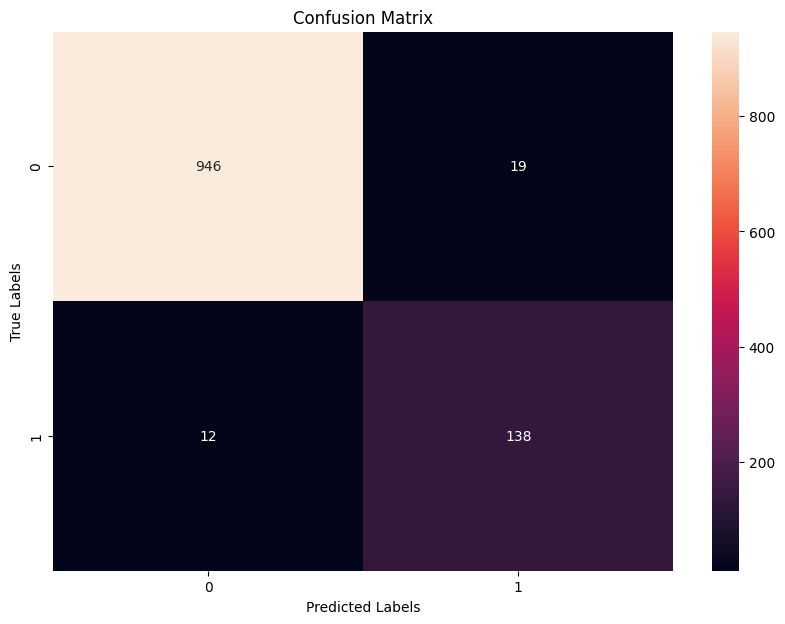

f1_score 0.8990228013029316
accuracy 0.9721973094170404


array([[946,  19],
       [ 12, 138]])

In [22]:
cm_1 = confusion_matrix(y_labels, y_pred_bin)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_1, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("f1_score",f1_score(y_val,y_pred_bin))
print("accuracy",accuracy_score(y_val,y_pred_bin))
cm_1

In [23]:
#GRU model

vocab_size = len(tokenizer.index_word)+1 #padding
model_gru = tf.keras.Sequential([
                Input([X_train_pad.shape[1],]),
                Embedding(vocab_size, 128, name="embedding"),
                GRU(units=128, return_sequences=True),
                GRU(units=64, return_sequences=False),
                Dense(32, activation='relu'),
                Dense(1, activation="sigmoid", name="last")
])

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 128)           1111936   
                                                                 
 gru (GRU)                   (None, 79, 128)           99072     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 last (Dense)                (None, 1)                 33        
                                                                 
Total params: 1250369 (4.77 MB)
Trainable params: 1250369 (4.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# Train GRU model

model_gru.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

class_weight = {0 : 0.577, 1 : 3.73}
history = model_gru.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    class_weight = class_weight
    )

Epoch 1/10
35/35 [==============================] - 24s 503ms/step - loss: 0.6935 - accuracy: 0.5064 - val_loss: 0.6968 - val_accuracy: 0.1345
Epoch 2/10
35/35 [==============================] - 16s 474ms/step - loss: 0.6932 - accuracy: 0.4606 - val_loss: 0.6793 - val_accuracy: 0.8655
Epoch 3/10
35/35 [==============================] - 17s 492ms/step - loss: 0.6932 - accuracy: 0.5739 - val_loss: 0.6799 - val_accuracy: 0.8655
Epoch 4/10
35/35 [==============================] - 20s 554ms/step - loss: 0.6931 - accuracy: 0.5068 - val_loss: 0.7003 - val_accuracy: 0.1363
Epoch 5/10
35/35 [==============================] - 17s 502ms/step - loss: 0.6927 - accuracy: 0.6354 - val_loss: 0.6920 - val_accuracy: 0.8655
Epoch 6/10
35/35 [==============================] - 22s 627ms/step - loss: 0.6927 - accuracy: 0.4380 - val_loss: 0.6933 - val_accuracy: 0.1363
Epoch 7/10
35/35 [==============================] - 17s 495ms/step - loss: 0.6927 - accuracy: 0.7839 - val_loss: 0.6919 - val_accuracy: 0.8655

In [25]:
#extract pred and target labels GRU
y_pred_2 = model_gru.predict(val_dataset)
y_pred_bin_2 = np.where(y_pred_2 > 0.5, 1, 0)
y_labels_2 = np.concatenate([y for x, y in val_dataset], axis=0)

9/9 [==============================] - 2s 123ms/step


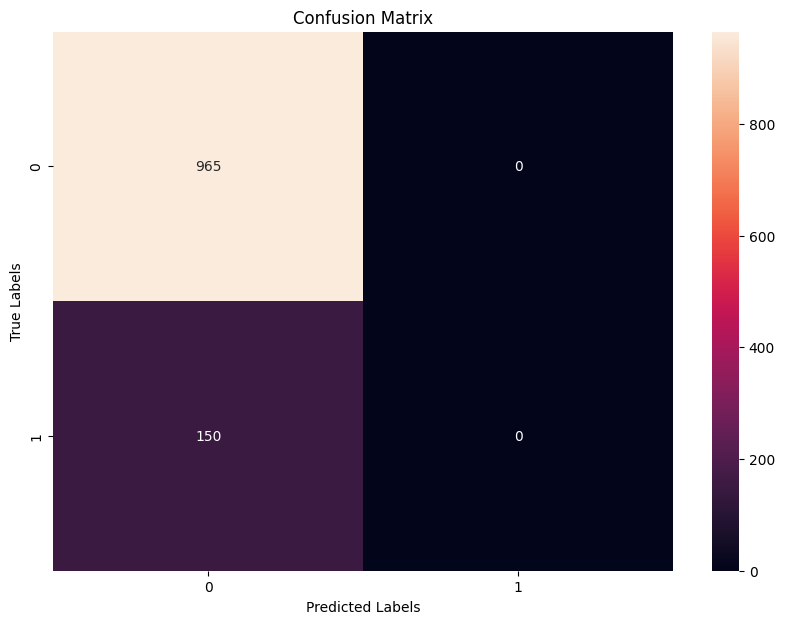

f1_score 0.0
accuracy 0.8654708520179372


array([[965,   0],
       [150,   0]])

In [26]:
cm_2 = confusion_matrix(y_labels_2, y_pred_bin_2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_2, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("f1_score",f1_score(y_val,y_pred_bin_2))
print("accuracy",accuracy_score(y_val,y_pred_bin_2))
cm_2

In [27]:
#LSTM model

vocab_size = len(tokenizer.index_word)+1 #padding
model_lstm = tf.keras.Sequential([
                Input([X_train_pad.shape[1],]),
                Embedding(vocab_size, 128, name="embedding"),
                LSTM(units=128, return_sequences=False),
                Dense(64, activation='relu'),
                Dense(1, activation="sigmoid", name="last")
])

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 128)           1111936   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 last (Dense)                (None, 1)                 65        
                                                                 
Total params: 1251841 (4.78 MB)
Trainable params: 1251841 (4.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# Train LSTM model

model_lstm.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

class_weight = {0 : 0.577, 1 : 3.73}
history = model_lstm.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    class_weight = class_weight
    )

Epoch 1/10
35/35 [==============================] - 20s 497ms/step - loss: 0.6944 - accuracy: 0.6937 - val_loss: 0.6967 - val_accuracy: 0.1363
Epoch 2/10
35/35 [==============================] - 14s 402ms/step - loss: 0.6932 - accuracy: 0.2740 - val_loss: 0.6996 - val_accuracy: 0.1354
Epoch 3/10
35/35 [==============================] - 13s 382ms/step - loss: 0.6929 - accuracy: 0.6787 - val_loss: 0.6984 - val_accuracy: 0.1363
Epoch 4/10
35/35 [==============================] - 14s 414ms/step - loss: 0.6930 - accuracy: 0.1342 - val_loss: 0.6964 - val_accuracy: 0.1363
Epoch 5/10
35/35 [==============================] - 13s 370ms/step - loss: 0.6930 - accuracy: 0.8228 - val_loss: 0.6898 - val_accuracy: 0.8655
Epoch 6/10
35/35 [==============================] - 14s 399ms/step - loss: 0.6930 - accuracy: 0.5899 - val_loss: 0.6914 - val_accuracy: 0.8655
Epoch 7/10
35/35 [==============================] - 14s 393ms/step - loss: 0.6928 - accuracy: 0.2968 - val_loss: 0.6944 - val_accuracy: 0.1363

# Transfer learning

In [ ]:
!pip install transformers[torch] accelerate -U
!pip install transformers datasets
from datasets import Dataset
import torch
import accelerate
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
print(f"PyTorch version: {torch.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

In [55]:
model_name = "mrm8488/bert-tiny-finetuned-sms-spam-detection"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [23]:
data_clean_2 = data_clean[["clean_text_msg","target"]]

In [77]:
encoded_dataset = Dataset.from_pandas(data_clean_2)

model_name = "mrm8488/bert-tiny-finetuned-sms-spam-detection"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Assuming binary classification

def tokenize_function(examples):
    return tokenizer(examples['clean_text_msg'], padding=True, truncation=True)

encoded_dataset = encoded_dataset.map(tokenize_function, batched=True)

train_data, val_data = train_test_split(encoded_dataset, test_size=0.2, random_state=42)

print(type(dataset_dict['train']), type(dataset_dict['validation']))

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['validation'],
)

trainer.train()


Map:   0%|          | 0/5572 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


<class 'dict'> <class 'dict'>


KeyError: 2

In [63]:
print(train_data.keys())  # Check keys of the first element in train_data
print(val_data.keys())

dict_keys(['clean_text_msg', 'target', 'input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['clean_text_msg', 'target', 'input_ids', 'token_type_ids', 'attention_mask'])


In [81]:
print(len(dataset_dict['train']), len(dataset_dict['validation']))

# Verify keys of the first example in train_dataset and eval_dataset
if len(dataset_dict['train']) > 0:
    print(dataset_dict['train'][0].keys())
else:
    print("Train dataset is empty!")

if len(dataset_dict['validation']) > 0:
    print(dataset_dict['validation'][0].keys())
else:
    print("Validation dataset is empty!")


5 5


KeyError: 0

In [42]:
# Preprocessing
encoded_dataset = Dataset.from_pandas(data_clean_2)

def prepare_training_data(data_dict):
  """
  Prepares training or validation data for the trainer.

  Args:
      data_dict (dict): A dictionary containing tokenized data points.

  Returns:
      tuple: A tuple containing input IDs, attention masks, and labels.
  """
  input_ids = []
  attention_masks = []
  labels = []
  for data_point in data_dict.values():
    input_ids.append(data_point['input_ids'])
    attention_masks.append(data_point['attention_mask'])
    labels.append(data_point['label'])
  return input_ids, attention_masks, labels

# tokenized_dataset = encoded_dataset.map(prepare_training_data, batched=True)

train_data, val_data = train_test_split(encoded_dataset, test_size=0.2, random_state=42)

# def convert_to_pytorch_dataset(dataset):
#     return Dataset.from_dict({k: torch.tensor(v) for k, v in dataset.items()})
# train_dataset = convert_to_pytorch_dataset(train_data)
# val_dataset = convert_to_pytorch_dataset(val_data)

In [43]:
# Training parameters

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [44]:
# Train model

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
)

trainer.train(
  train_dataset=prepare_training_data(train_data),
  eval_dataset=prepare_training_data(val_data),
)

TypeError: list indices must be integers or slices, not str

In [ ]:
trainer.evaluate()

# Process explanation

### 1st tests
I tryied different model configurations using SimpleRNN, GRU and LSTM.
I directly used the full dataset, first forgetting to balance classes, then with class_weight ponderations. None of the models didn't really train.

### 2nd tests
I tryied to change other parameters, such as the number of neurons and layers for the models, as well as increasing the batch size to 128 instead of 32 or 64 tested before.
The batch size increase clearly let the model train, and from my empirical approach and as far as I could test, it seems that a simple RNN model with one layer of 128 neurons produce the better results.
Concerning GRU and LSTM, I didn't manage to obtain results even after a lot of attempts.

### 3rd test
Tryied to perform transfer learning.
I was curious about transformers models and wanted to understand more how to apprehend them, that's why I found a model on Hugging face that appears to have a lot of credit (15k+ dld last month) which is a Bert model for spam detection finetuned on a sms dataset.
Unfortunately I didn't manage to train it on my dataset, probably due to an accessibility problem of the model when looping over my encoded dataset... I missed time to be able to solve this issue but will assurently get back to it.
